## Convolutional Variational AutoEncoder (VAE)

Step1: Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

/home/taha/anaconda3/envs/shujaatplay/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step2: Select Device

In [2]:
cuda = True
device = torch.device("cuda:0" if cuda else "cpu")
print(f"Using {device} device")

Using cuda:0 device


Step3: Load Dataset

In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified


Step4: Defining VAE Model

In [4]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.Tanh()
        )
        
        self.z_mean_layer = nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0)
        self.z_log_var_layer = nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0)
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 32, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 32, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0),
            nn.Tanh()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        z_mean = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        return z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std
    
    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_recon = self.decoder(z)
        return x_recon, z_mean, z_log_var

Step5: Loss Function

In [5]:
def vae_loss(x_recon, x, z_mean, z_log_var):
    
    reconstruction_loss = nn.MSELoss(reduction='mean')(x_recon, x)
    
    kl_divergence = 0.01 * (-0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp()))
    return reconstruction_loss + kl_divergence

Step6: Optimizer and Model Summary

In [6]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
print(vae)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
  )
  (z_mean_layer): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (z_log_var_layer): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Sequential(
    (0): ConvTranspose2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): ConvTranspose2d(32, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): Conv2d(32, 3,

In [7]:
from torchinfo import summary
summary(vae, input_size=(256, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [256, 3, 32, 32]          --
├─Sequential: 1-1                        [256, 32, 8, 8]           --
│    └─Conv2d: 2-1                       [256, 32, 16, 16]         4,736
│    └─BatchNorm2d: 2-2                  [256, 32, 16, 16]         64
│    └─Tanh: 2-3                         [256, 32, 16, 16]         --
│    └─Conv2d: 2-4                       [256, 32, 8, 8]           50,208
│    └─BatchNorm2d: 2-5                  [256, 32, 8, 8]           64
│    └─Tanh: 2-6                         [256, 32, 8, 8]           --
├─Conv2d: 1-2                            [256, 3, 8, 8]            99
├─Conv2d: 1-3                            [256, 3, 8, 8]            99
├─Sequential: 1-4                        [256, 3, 32, 32]          --
│    └─ConvTranspose2d: 2-7              [256, 32, 16, 16]         4,736
│    └─BatchNorm2d: 2-8                  [256, 32, 16, 16]         64
│    

Step7: Training

In [11]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs, z_mean, z_log_var = vae(inputs)
        loss = vae_loss(outputs, inputs, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader)}')

print('Finished Training')

Epoch [1/200] Loss: 0.04045039578816112
Epoch [2/200] Loss: 0.03861458337276566
Epoch [3/200] Loss: 0.03735891564236003
Epoch [4/200] Loss: 0.0367421101854772
Epoch [5/200] Loss: 0.035973528761188596
Epoch [6/200] Loss: 0.0355696863285741
Epoch [7/200] Loss: 0.035229245980023124
Epoch [8/200] Loss: 0.035000543794309606
Epoch [9/200] Loss: 0.03471293783157456
Epoch [10/200] Loss: 0.03451428493979026
Epoch [11/200] Loss: 0.03444605073606481
Epoch [12/200] Loss: 0.03431861406686355
Epoch [13/200] Loss: 0.03427701124123165
Epoch [14/200] Loss: 0.03405516281039739
Epoch [15/200] Loss: 0.03400606578406023
Epoch [16/200] Loss: 0.03389471946094109
Epoch [17/200] Loss: 0.03390193460699247
Epoch [18/200] Loss: 0.03385069953011615
Epoch [19/200] Loss: 0.03367500047066382
Epoch [20/200] Loss: 0.03380983001647555
Epoch [21/200] Loss: 0.03361587716760684
Epoch [22/200] Loss: 0.03353437319473953
Epoch [23/200] Loss: 0.03344244546047887
Epoch [24/200] Loss: 0.03345876312529554
Epoch [25/200] Loss: 0.0

Step8: Plotting Results

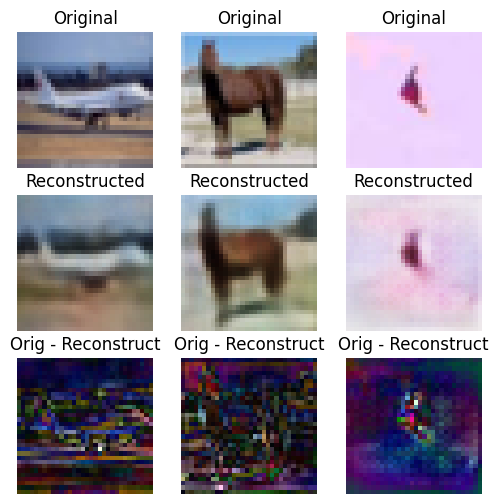

In [15]:
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):
    # Display original image
    ax = plt.subplot(3, n, i + 1)
    plt.title("Original")
    plt.imshow((inputs[i] * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis("off")

    # Display reconstructed image
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow((outputs[i] * 0.5 + 0.5).permute(1, 2, 0).detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis("off")

    # Display difference between original and reconstructed
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("Orig - Reconstruct")
    residual = torch.abs(inputs[i] - outputs[i])
    residual = (residual / residual.max()).permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(residual)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis("off")

plt.show()

In [15]:
# Testing
vae.eval()
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        reconstructed, _, _ = vae(data)
        break

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


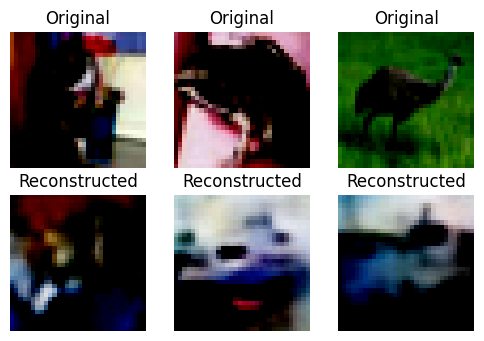

In [16]:
# Plot original and reconstructed images
n = 3
plt.figure(figsize=(6, 6))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.title("Original")
    plt.imshow(inputs[i].cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")

    plt.subplot(3, n, i + n + 1)
    plt.title("Reconstructed")
    plt.imshow(reconstructed[i].cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")

plt.show()